In [118]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [ ]:
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from gph import ripser_parallel
from matplotlib.cm import tab10
from rich import print as rprint
from safetensors import safe_open
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, Subset
from torcheval.metrics import MulticlassAccuracy

from analysis.utils import load_autoencoder, load_model, scatter
from koopmann.aesthetics import ibmplexsans, kill_axes, kill_ticks
from koopmann.data import DatasetConfig, get_dataset_class
from koopmann.shape_metrics import prepare_acts, undo_preprocessing_acts
from koopmann.utils import get_device, set_seed

set_seed(21)

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Control panel

In [121]:
mlp_file_dir = "/scratch/nsa325/koopmann_model_saves"
data_root = "/scratch/nsa325/datasets/"
dataset_name = "mnist"
model_name = f"resmlp_{dataset_name}"
ae_file_dir = f"/scratch/nsa325/koopmann_model_saves/{dataset_name}"
device = get_device()

Load model

In [122]:
model, model_metadata = load_model(mlp_file_dir, model_name)
model.hook_model().eval().to(device)
rprint("MLP Metadata: ", model_metadata)

MLP Metadata: 
{
    'batchnorm': True,
    'bias': True,
    'created_at': '2025-04-09T02:41:58.432513',
    'dataset': 'MNISTDataset',
    'hidden_config': [784, 784, 784, 784],
    'in_features': 784,
    'model_class': 'ResMLP',
    'nonlinearity': 'relu',
    'out_features': 10,
    'stochastic_depth_mode': 'batch',
    'stochastic_depth_prob': 0.0
}

Preprocessing neural representations in MLP

In [123]:
# Build dataset
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"], num_samples=5_000, split="train", seed=42
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config, root=data_root)

batch_size = 10_000
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


_, _, full_preproc_dict = prepare_acts(
    data_train_loader=dataloader,
    model=model,
    device=device,
    svd_dim=784,
    whiten_alpha=1.0,
    preprocess=True,
    # preprocess_dict=preproc_dict,
    only_first_last=False,
)

Processing activations: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]


Load dataset

In [124]:
# Build dataset
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"], num_samples=2_000, split="test", seed=42
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config, root=data_root)
labels = dataset.labels.squeeze()

# Grab subset of dataset
subset_size = None
if subset_size:
    subset_indices = list(range(0, subset_size))
    subset = Subset(dataset, subset_indices)

# Make dataloader
batch_size = 5_000
batch_size = min(subset_size, batch_size) if subset_size else batch_size
dataloader = DataLoader(subset if subset_size else dataset, batch_size=batch_size, shuffle=False)

Load autoencoders

In [125]:
ae_files = sorted(os.listdir(ae_file_dir))
ae_files = [
    Path(file) for file in ae_files if ("autoencoder" in file and "preprocessing" not in file)
]

In [126]:
autoencoders_list = []
preprocs_list = []
proc_act_dict_list = []

for ae_file in ae_files:
    autoencoder, ae_metadata = load_autoencoder(ae_file_dir, ae_file.stem)
    autoencoders_list.append(autoencoder.eval().to(device))

    preproc_dict = {}
    with safe_open(
        f"{ae_file_dir}/{ae_file.stem}_preprocessing.safetensors", framework="pt", device=device
    ) as f:
        for k in f.keys():
            preproc_dict[k] = f.get_tensor(k)

    preprocs_list.append(preproc_dict)
    rprint(ae_file.stem)

    _, processed_act_dict, _ = prepare_acts(
        data_train_loader=dataloader,
        model=model,
        device=device,
        svd_dim=ae_metadata["in_features"],
        whiten_alpha=preproc_dict["wh_alpha_0"],
        preprocess=True,
        preprocess_dict=preproc_dict,
        only_first_last=True,
    )
    proc_act_dict_list.append(processed_act_dict)
    k_steps = ae_metadata["k_steps"]
    # rprint("Autoencoder: ", ae_metadata)

dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_21

Processing activations: 100%|██████████| 2/2 [00:00<00:00, 29.21it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_365

Processing activations: 100%|██████████| 2/2 [00:00<00:00, 29.69it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_53

Processing activations: 100%|██████████| 2/2 [00:00<00:00, 29.02it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_74

Processing activations: 100%|██████████| 2/2 [00:00<00:00, 29.44it/s]


dim_800_k_10_loc_1_exponential_autoencoder_mnist_model_seed_99

Processing activations: 100%|██████████| 2/2 [00:00<00:00, 26.09it/s]


In [127]:
def get_betti_numbers(data, max_dim, eps):
    result = ripser_parallel(data, maxdim=max_dim, thresh=eps, n_threads=-1)
    betti_numbers = {}

    for dim in range(max_dim + 1):
        dgm = result["dgms"][dim]
        count = 0
        for birth, death in dgm:
            if birth <= eps and (death > eps or np.isinf(death)):
                count += 1
        betti_numbers[dim] = count

    return betti_numbers

In [128]:
MAX_DIM = 0
EPS = 0.14
betti_per_run = {}  # Dictionary to store all Betti numbers
with torch.no_grad():
    for i, (autoencoder, proc_act_dict) in enumerate(zip(autoencoders_list, proc_act_dict_list)):
        # Run KAE
        preds = autoencoder.forward(proc_act_dict[0], intermediate=True, k=k_steps).predictions
        idx = range(len(preds))

        # Initialize dictionary for this run if it doesn't exist
        if i not in betti_per_run:
            betti_per_run[i] = {dim: [] for dim in range(MAX_DIM + 1)}

        # Compute Betti numbers for all intermediates
        for j, pred in enumerate(preds):
            betti_numbers = get_betti_numbers(data=pred, max_dim=MAX_DIM, eps=EPS)

            for dim in range(MAX_DIM + 1):
                betti_per_run[i][dim].append(betti_numbers[dim])


In [129]:
preds.shape

torch.Size([11, 10000, 784])

In [130]:
MAX_DIM = 0
EPS = 0.166
# EPS = 0.46
with torch.no_grad():
    _, full_processed_act_dict, _ = prepare_acts(
        data_train_loader=dataloader,
        model=model,
        device=device,
        svd_dim=784,
        whiten_alpha=1.0,
        preprocess=True,
        preprocess_dict=full_preproc_dict,
        only_first_last=False,
    )

    betti_numbers_mlp = {0: []}
    betti_numbers_mlp[0] = {dim: [] for dim in range(MAX_DIM + 1)}

    for rep in full_processed_act_dict.values():
        betti_numbers = get_betti_numbers(data=rep, max_dim=MAX_DIM, eps=EPS)

        for dim in range(MAX_DIM + 1):
            betti_numbers_mlp[0][dim].append(betti_numbers[dim])

Processing activations: 100%|██████████| 5/5 [00:00<00:00, 29.31it/s]


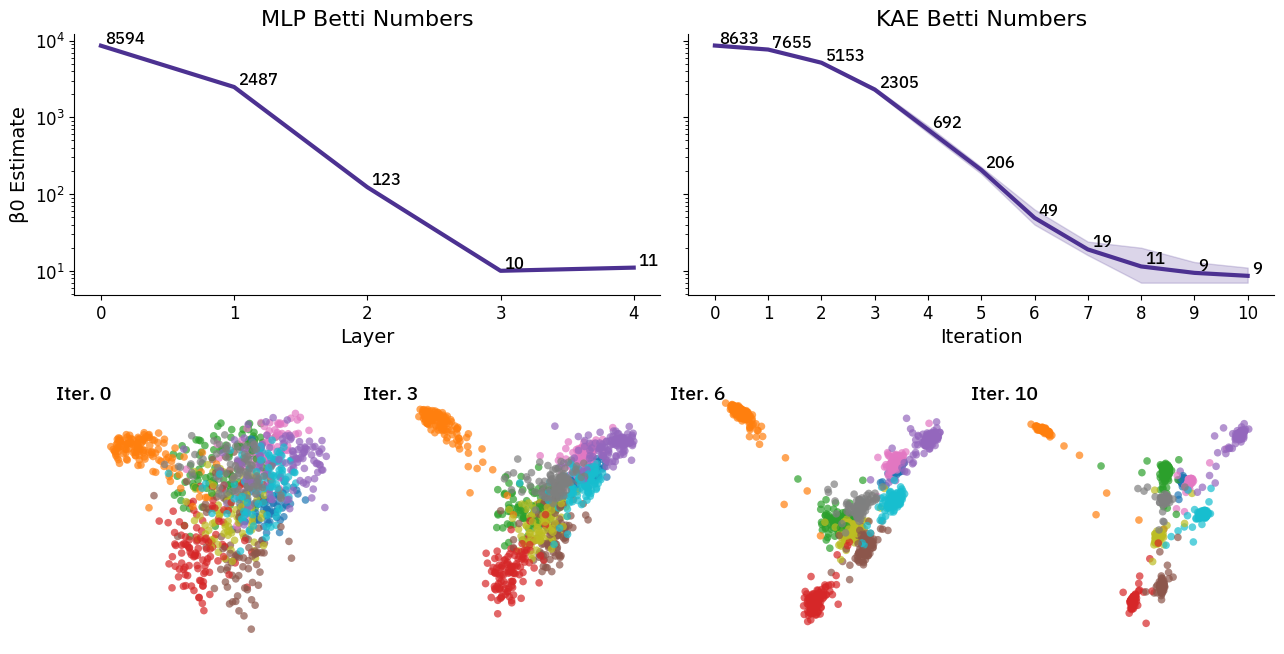

In [131]:
# Create figure with GridSpec
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 4, figure=fig, wspace=0.1, hspace=0.3)
gs.update(left=0, right=0.8, top=1, bottom=0)


# Helper function for common plotting pattern
def plot_annotated_betti_numbers(ax, x, y, fill_data=None):
    ax.plot(x, y, linewidth=3, color="#4c3191")
    ax.set_xticks(x)
    for xi, yi in zip(x, y):
        ax.annotate(
            f"{yi:.0f}",
            (xi, yi),
            xytext=(3, 5.5),
            textcoords="offset points",
            fontsize=12,
            va="center",
            font=ibmplexsans,
        )
    if fill_data:
        ax.fill_between(x, fill_data[0], fill_data[1], alpha=0.2, color="#4c3191")


# Process KAE data
def arrange_data(betti_per_run, dim):
    runs = list(run[dim] for run in betti_per_run.values())
    data = np.array([[run[j] for run in runs] for j in idx]).T
    min, mean, max = [f(data, axis=0) for f in (np.min, np.mean, np.max)]
    return min, mean, max


##### BETTI NUMBERS
# First subplot (MLP data)
ax1 = fig.add_subplot(gs[0, :2])
plot_annotated_betti_numbers(ax1, range(len(betti_numbers_mlp[0][0])), betti_numbers_mlp[0][0])
ax1.set_title("MLP Betti Numbers")
ax1.set_xlabel("Layer")

# Second subplot (KAE data)
b0_min, b0_mean, b0_max = arrange_data(betti_per_run=betti_per_run, dim=0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax1)
plot_annotated_betti_numbers(ax2, idx, b0_mean, fill_data=(b0_min, b0_max))
ax2.set_title("KAE Betti Numbers")
ax2.set_xlabel("Iteration")
ax2.tick_params(axis="y", labelright=False, labelleft=False)

# Common styling
ax1.set_yscale("log")
ax1.set_ylabel(f"β{0} Estimate")
for ax in [ax1, ax2]:
    sns.despine(ax=ax)

##### SCATTER
size = 1_000
labels = [str(t.item()) for t in dataset.labels[:size]]
classes = sorted(set(labels))

palette = [tab10(i) for i in range(10)]  # Get the first 10 colors from Tableau10

# Map labels to colors
colors = [palette[classes.index(label) % 10] for label in labels]

iters = [0, 3, 6, 10]
subset_preds = [preds[t] for t in iters]
pca = PCA(n_components=3)
reference = pca.fit_transform(subset_preds[0][:size])
for i, pred in enumerate(subset_preds):
    red_coords = pca.fit_transform(pred[:size])
    _, red_coords, _ = procrustes(reference, red_coords)
    ax = fig.add_subplot(gs[1, i], projection="3d")
    ax.scatter(
        red_coords[:, 0],
        red_coords[:, 1],
        red_coords[:, 2],
        s=30,
        alpha=0.7,
        edgecolors="none",
        c=colors,
    )
    ax.text2D(
        0,
        0.9,
        f"Iter. {iters[i]}",
        fontsize=14,
        font=ibmplexsans,
        ha="center",
        transform=ax.transAxes,
    )
    kill_ticks(ax)
    kill_axes(ax)
    ax.margins(0, 0, 0)  # Remove any internal margins

    ax.view_init(elev=-30, azim=90)
    ax.set_box_aspect([1, 1, 1], zoom=1.4)


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(
    {
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)
# plt.savefig("topology.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


In [132]:
# with torch.no_grad():
#     init_idx = 0
#     final_idx = 4
#     pred_proj = autoencoder.forward(
#         proc_act_dict[init_idx], intermediate=True, k=k_steps
#     ).predictions[-1]

#     pred = undo_preprocessing_acts(pred_proj, preproc_dict, final_idx, device)
#     test_labels = dataset.labels[:subset_size]


# reduced = PCA(n_components=3).fit_transform(pred)
# scatter(x=reduced[:, 0], y=reduced[:, 1], z=reduced[:, 2], labels=dataset.labels[:subset_size])

# pred = model.components[-1:](pred)
# per_class_metric = MulticlassAccuracy(num_classes=dataset.out_features, average=None)
# per_class_metric.update(pred, test_labels.to(torch.long))
# print("Koopman accuracy per class:", per_class_metric.compute())

In [133]:
# full_preproc_dict["norm_0"]

In [134]:
# preprocs_list[1]["norm_0"]